# Clustering with K-Means
- Select Area 1 for analysis because it has the highest concentration of crime. 

In [1]:
from pyspark.sql import functions as F
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import folium
from folium.plugins import HeatMap, MarkerCluster, AntPath
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde


In [2]:
%load_ext autoreload
%autoreload 2
import sys; 
import sys; sys.path.insert(0, 'lib/')
from libs import utils, genetic_algo

In [3]:
data_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"
# Read and Clean Data
spark = utils.start_spark()
df = utils.prepare_data(spark, data_path)
# Additional feature engineering - add more features
df = utils.feature_engineering(df)
columns_drop = ["AREA NAME", 
                "Rpt Dist No", 
                "Part 1-2", 
                "Crm Cd", 
                "Crm Cd Desc", 
                "Mocodes", 
                "Premis Cd",
                "Premis Desc",
                "Weapon Used Cd",
                "Weapon Desc",
                "Status Desc",
                "LOCATION",
                "age_group",
                "Date Rptd",
                "DATE OCC",
                "TIME OCC"]
df_dropped = utils.drop_columns(df, columns_drop)
df_clean = df_dropped.dropna(subset=["Vict Age"])

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/08 21:37:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 57704)
Traceback (most recent call last):
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12

In [4]:
df_clean.show()

+----+--------+--------+--------------------+------+-------+---------+-------------------+--------+---------+-------+------------------+
|AREA|Vict Age|Vict Sex|        Vict Descent|Status|    LAT|      LON|       Occ DateTime|Year OCC|Month OCC|Day OCC|          Category|
+----+--------+--------+--------------------+------+-------+---------+-------------------+--------+---------+-------+------------------+
|   1|      47|       M|               Other|    IC|34.0444|-118.2628|2020-02-08 18:00:00|    2020|        2|      8|              BTFV|
|   3|      19|       X|             Unknown|    IC| 34.021|-118.3002|2020-11-04 17:00:00|    2020|       11|      4|       OTHER THEFT|
|   9|      19|       M|               Other|    IC|34.1576|-118.4387|2020-03-10 20:37:00|    2020|        3|     10|       OTHER THEFT|
|   6|      28|       M|Hispanic/Latin/Me...|    IC|34.0944|-118.3277|2020-08-17 12:00:00|    2020|        8|     17|    IDENTITY THEFT|
|  18|      41|       M|Hispanic/Latin/Me

In [5]:
df_pd = df_clean.toPandas()
df_pd.head()

24/11/08 21:37:47 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


,AREA,Vict Age,Vict Sex,Vict Descent,Status,LAT,LON,Occ DateTime,Year OCC,Month OCC,Day OCC,Category
0,1,47,M,Other,IC,34.0444,-118.2628,2020-02-08 18:00:00,2020,2,8,BTFV
1,3,19,X,Unknown,IC,34.0210,-118.3002,2020-11-04 17:00:00,2020,11,4,OTHER THEFT
2,9,19,M,Other,IC,34.1576,-118.4387,2020-03-10 20:37:00,2020,3,10,OTHER THEFT
3,6,28,M,Hispanic/Latin/Mexican,IC,34.0944,-118.3277,2020-08-17 12:00:00,2020,8,17,IDENTITY THEFT
4,18,41,M,Hispanic/Latin/Mexican,IC,33.9467,-118.2463,2020-12-01 23:00:00,2020,12,1,IDENTITY THEFT


In [6]:
df_clean_lat_lon[["LAT", "LON", "Category"]].groupby(["LAT", "LON"]).count().sort_values(by="Category", ascending=False)
df_clean_lat_lon[["AREA", "Category"]].groupby("AREA").count().sort_values(by="Category", ascending=False)

,Category
AREA,
1,50751
3,46727
12,45617
14,41072
6,38277
18,36078
15,35436
20,35432
7,34895


## Focusing on Area 1

In [21]:
df_central = df_clean_lat_lon[df_clean_lat_lon["AREA"]==1]
# removing 2024 as the data for 2024 is incomplete might affect the analysis
df_central = df_central[df_central["Year OCC"]!=2024]
# dropping the Vict Sex, Vict Descent, Status but keeping the category
df_clustering = df_central[["LAT", "LON", "Occ DateTime", "Year OCC", "Month OCC", "Day OCC", "Category"]]


In [22]:
# Handle datatime
df_clustering["Occ DateTime"] = pd.to_datetime(df_clustering["Occ DateTime"])
df_clustering["hour"] = df_clustering["Occ DateTime"].dt.hour
df_clustering["hour_sin"] = np.sin(2*np.pi *df_clustering["hour"]/24)
df_clustering["hour_cos"] = np.cos(2*np.pi *df_clustering["hour"]/24)
# Scaling the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clustering[['Day OCC', 'hour_sin', 'hour_cos']])
df_clustering = df_clustering[["LAT", "LON", "Year OCC", "Month OCC", "Day OCC", "Category", "hour_sin", "hour_cos"]]

/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_62333/4252708684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering["Occ DateTime"] = pd.to_datetime(df_clustering["Occ DateTime"])
/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_62333/4252708684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering["hour"] = df_clustering["Occ DateTime"].dt.hour
/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_62333/4252708684.py:4: SettingWithCopyWarning: 
A value i

In [23]:
print(df_clustering.shape)

df_clustering_encoded = pd.get_dummies(df_clustering, columns=["Category"], drop_first=True)
print(df_clustering_encoded.shape)

(46462, 8)
(46462, 26)


Do K-Means

In [26]:
n_clusters = 10
kmeans_central = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_central.fit(df_clustering_encoded)


array([1, 6, 6, ..., 5, 3, 6], dtype=int32)

In [27]:
df_clustering_encoded["cluster"] = kmeans_central.labels_
df_clustering_encoded.head()

,LAT,LON,Year OCC,Month OCC,Day OCC,hour_sin,hour_cos,Category_AGG. ASSAULTS (DV),Category_ARSON,Category_All Other Offenses,...,Category_MVT (GTA),Category_OTHER THEFT,Category_PERSONAL THFT,Category_RAPE,Category_ROBBERY,Category_SIMPLE ASSAULT,Category_SIMPLE ASSAULT (DV),Category_Trespassing,Category_Vandalism,cluster
0,34.0444,-118.2628,2020,2,8,-1.000000,-1.836970e-16,False,False,False,...,False,False,False,False,False,False,False,False,False,1
5,34.0415,-118.2620,2020,7,3,0.707107,-7.071068e-01,False,False,False,...,False,False,False,False,False,False,False,False,False,6
50,34.0466,-118.2590,2020,7,1,0.258819,-9.659258e-01,False,False,False,...,False,False,False,False,False,False,False,False,False,6
101,34.0570,-118.2508,2020,8,27,-0.707107,7.071068e-01,True,False,False,...,False,False,False,False,False,False,False,False,False,0
117,34.0438,-118.2547,2020,4,10,0.500000,8.660254e-01,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [45]:
df_clustering.head()
df_spatial = df_clustering[["LAT", "LON"]]


In [46]:
wcss = []  # List to store WCSS for each k

# Loop through a range of k values
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_spatial)  # Fit K-means
    wcss.append(kmeans.inertia_)  # Append WCSS (inertia) for this k

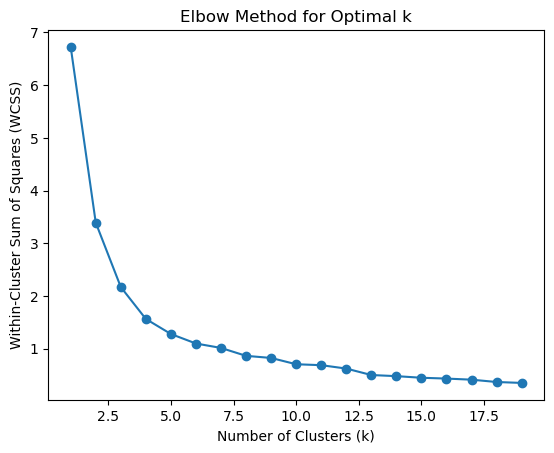

In [47]:
# Plotting the WCSS values for each k
plt.plot(range(1, 20), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [52]:
n_clusters = 10
kmeans_central = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_central.fit(df_spatial)
df_spatial["cluster"] = kmeans_central.labels_
df_spatial.head()

/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_62333/2396172742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spatial["cluster"] = kmeans_central.labels_


,LAT,LON,cluster
0,34.0444,-118.2628,1
5,34.0415,-118.2620,7
50,34.0466,-118.2590,1
101,34.0570,-118.2508,0
117,34.0438,-118.2547,7


In [56]:
m = folium.Map(location=[df_spatial['LAT'].mean(), df_spatial['LON'].mean()], zoom_start=20)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'red', 'blue', 'green', 'purple']
# Add points to the map
count = 0
for i, row in df_spatial.iterrows():
    count+=1
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=8,
        color=colors[int(row['cluster'])],
        fill=True,
        fill_color=colors[int(row['cluster'])],
        fill_opacity=0.6,
        popup=f"Cluster: {int(row['cluster'])}"
    ).add_to(m)
print(count)

m.save('markers_central_10_kmeans.html')

46462


/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_62333/2863074408.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


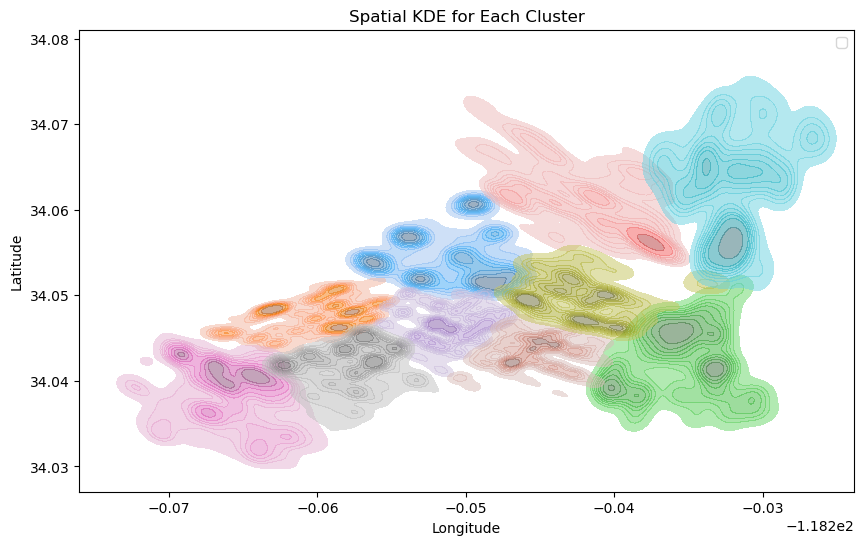

In [58]:
# Plot KDE for each cluster
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(df_spatial["cluster"]):
    if cluster_id == -1:
        continue  # Skip noise points

    cluster_data = df_spatial[df_spatial["cluster"] == cluster_id]
    sns.kdeplot(x=cluster_data["LON"], y=cluster_data["LAT"], 
                fill=True, label=f"Cluster {cluster_id}", alpha=0.5)

plt.title("Spatial KDE for Each Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

Find the hotspots for each clusters.

In [65]:
densest_points = []
for cluster_id in np.unique(df_spatial["cluster"]):
    if cluster_id == -1:
        continue  # Skip noise points

    cluster_data = df_spatial[df_spatial["cluster"] == cluster_id]
    
    # Apply KDE on cluster
    kde = gaussian_kde(cluster_data[['LAT', 'LON']].T)
    
    # Define grid for KDE evaluation
    lat_min, lat_max = cluster_data['LAT'].min() - 0.01, cluster_data['LAT'].max() + 0.01
    lon_min, lon_max = cluster_data['LON'].min() - 0.01, cluster_data['LON'].max() + 0.01
    lat_grid, lon_grid = np.mgrid[lat_min:lat_max:100j, lon_min:lon_max:100j]
    positions = np.vstack([lat_grid.ravel(), lon_grid.ravel()])
    density = kde(positions).reshape(lat_grid.shape)
    
    # Find the index of the maximum density value
    max_density_index = np.unravel_index(np.argmax(density), density.shape)
    max_density_coords = lat_grid[max_density_index], lon_grid[max_density_index]
    densest_points.append(max_density_coords)


In [73]:
lat, lon = zip(*densest_points)
mean_lat = sum(lat)/len(lat)
mean_lon = sum(lon)/len(lon)


In [77]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=15)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'red', 'blue', 'green', 'purple']
# Add points to the map
count = 0
for i, location in enumerate(densest_points):
    count+=1
    folium.CircleMarker(
        location=(location[0], location[1]),
        radius=8,
        color=colors[i],
        fill=True,
        fill_color=colors[i],
        fill_opacity=0.6
    ).add_to(m)
print(count)

m.save('markers_hotspots_kde.html')  # Display map in Jupyter Notebook or save with m.save('map.html')

10


In [78]:
print(densest_points)

[(34.05148181818182, -118.24846262626262), (34.048346464646464, -118.26297575757576), (34.04564242424242, -118.23569292929294), (34.056265656565664, -118.23746565656565), (34.04675454545455, -118.2518797979798), (34.04220404040404, -118.24699090909091), (34.04067272727273, -118.26442828282828), (34.04231818181818, -118.25600707070707), (34.0495101010101, -118.24588080808081), (34.05615252525253, -118.23196060606061)]


In [62]:
# Apply KDE
kde = gaussian_kde(df_spatial[['LAT', 'LON']].T)

# Define grid for KDE evaluation
lat_min, lat_max = df_spatial['LAT'].min() - 0.01, df_spatial['LAT'].max() + 0.01
lon_min, lon_max = df_spatial['LON'].min() - 0.01, df_spatial['LON'].max() + 0.01
lat_grid, lon_grid = np.mgrid[lat_min:lat_max:100j, lon_min:lon_max:100j]
positions = np.vstack([lat_grid.ravel(), lon_grid.ravel()])
density = kde(positions).reshape(lat_grid.shape)

# Find the index of the maximum density value
max_density_index = np.unravel_index(np.argmax(density), density.shape)
max_density_coords = lat_grid[max_density_index], lon_grid[max_density_index]

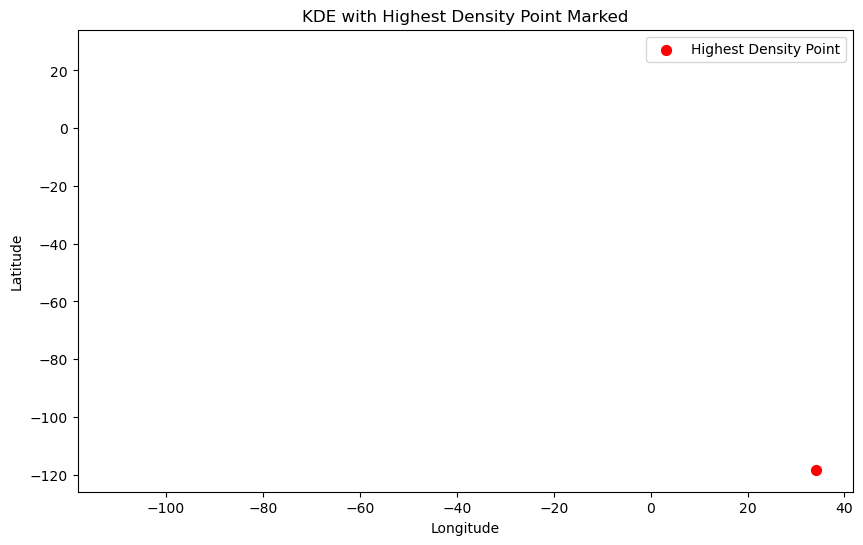

In [63]:
# Plot KDE and highlight the highest density point
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df_spatial['LON'], y=df_spatial['LAT'], fill=True, cmap="viridis")
plt.scatter(*max_density_coords, color='red', s=50, label="Highest Density Point")
plt.legend()
plt.title("KDE with Highest Density Point Marked")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [64]:
print("Highest Density Point Coordinates:", max_density_coords)


Highest Density Point Coordinates: (34.04579696969697, -118.25098181818181)


## Using Elbow Method to determine the best K

In [37]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = []  # List to store WCSS for each k

# Loop through a range of k values
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_clustering_encoded)  # Fit K-means
    wcss.append(kmeans.inertia_)  # Append WCSS (inertia) for this k


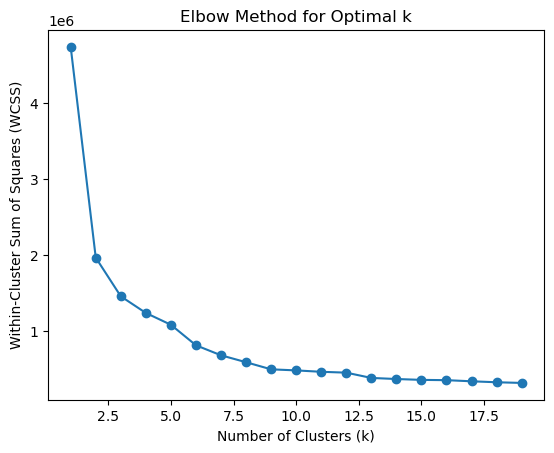

In [38]:
# Plotting the WCSS values for each k
plt.plot(range(1, 20), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [40]:
df_clustering_encoded[["LAT", "cluster"]].groupby("cluster").count().sort_values(by="LAT", ascending=False)

,LAT
cluster,
0,5475
5,5461
7,5194
2,4984
3,4881
6,4480
9,4262
4,4046
8,3971


In [41]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[df_clustering_encoded['LAT'].mean(), df_clustering_encoded['LON'].mean()], zoom_start=12)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'red', 'blue', 'green', 'purple', 'lightblue', 'lightgreen', 'gray', 'black']
marker_cluster = MarkerCluster().add_to(m)
# Add points to the map
for i, row in df_clustering_encoded.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=4,
        color=colors[row['cluster']],
        fill=True,
        fill_color=colors[row['cluster']],
        fill_opacity=0.6,
        popup=f"Cluster: {row['cluster']}"
    ).add_to(marker_cluster)

m.save('central_cluster_k-means10.html')

In [43]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[df_clustering_encoded['LAT'].mean(), df_clustering_encoded['LON'].mean()], zoom_start=20)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'red', 'blue', 'green', 'purple']
# Add points to the map
count = 0
for i, row in df_clustering_encoded.iterrows():
    count+=1
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=8,
        color=colors[row['cluster']],
        fill=True,
        fill_color=colors[row['cluster']],
        fill_opacity=0.6,
        popup=f"Cluster: {row['cluster']}"
    ).add_to(m)
print(count)

m.save('markers_central_10_kmeans.html')  # Display map in Jupyter Notebook or save with m.save('map.html')


46462


In [ ]:
# Plot KDE for each cluster
plt.figure(figsize=(10, 6))
for cluster_id in np.unique(clusters):
    if cluster_id == -1:
        continue  # Skip noise points

    cluster_data = data[clusters == cluster_id]
    sns.kdeplot(x=cluster_data[:, 1], y=cluster_data[:, 0], 
                fill=True, label=f"Cluster {cluster_id}", alpha=0.5)

plt.title("Spatial KDE for Each Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

1 - Filter AREA 1
- lat
- lon
- day
- hour
- predict (1am)
RMSE 
2 - all area
- lat
- lon
- day
- hour (4pm)
RSME

10 lat lon
x 7 day = 1-7
70 prediction hour

Monday
- 3 shifts 
    - hotspost (routing)
genetic algorithm - 1, 2, 3, 4, 5
openstreet api - proper routing (traffic)

0:00 - 7.59
8.00 - 3.59
4pm - 11.59pm